In [ ]:
import numpy as np
import pandas as pd
from datetime import datetime
import matplotlib
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from scipy.optimize import minimize_scalar, minimize
from scipy.stats import multivariate_normal

import dbesg

In [2]:
# 환경설정
font_name = matplotlib.font_manager.FontProperties(fname="c:/Windows/Fonts/malgun.ttf").get_name()
matplotlib.rcParams['axes.unicode_minus'] = False
krfont = {'family':font_name, 'size':10}
matplotlib.rc('font', **krfont)
plt.style.use("ggplot")
pd.options.display.float_format = '{:,.3f}'.format

In [277]:
class SmithWilson:
    
    """
        Example
        -------
            >>> data = np.array([
                    [1, 0.01301],
                    [3, 0.01325],
                    [5, 0.01415],
                    [10, 0.01600],
                    [20, 0.01625],
                    [30, 0.01604]
                ])

            >>> X_train = data[:, 0]
            >>> y_train = data[:, 1]
            >>> ufr = 0.045
            >>> terminal = 60

            >>> sw = SmithWilson(np.log(1+ufr), terminal)
            >>> sw.train(X_train, y_train)

            >>> maturity = np.linspace(1/12, 100, 1200)
            >>> spot_rate = sw.spot(maturity)
            >>> bond_price = sw.bond(maturity)
            >>> forward_rate = sw.forward(maturity)
    """
    
    def __init__(self, ufr, terminal):
        self.ufr = ufr
        self.terminal = terminal
    
    def train(self, X, y):
        m = 1/(1+y)**X
        mu = np.exp(-self.ufr*X)
        n = len(X)
        
        def obj_fun(alpha):
            W = self._wilson(X[:, None], X, alpha)
            zeta = (m-mu)@np.linalg.inv(W)
            W_T = self._wilson(self.terminal, X, alpha)
            derivW_T = self._wilson(self.terminal, X, alpha, order=1)
            bond0_T = np.exp(-self.ufr*self.terminal) + W_T@zeta
            bond1_T = -self.ufr*np.exp(-self.ufr*self.terminal)+derivW_T@zeta
            forward_T = -bond1_T/bond0_T
            error = abs(1e-4-abs(forward_T-self.ufr))
            return error
        
        res = minimize_scalar(obj_fun, method='bounded', bounds=(1e-4,1), options={'disp':False})
        self._alpha = res.x
        W = self._wilson(X[:, None], X, self._alpha)
        self._zeta = (m-mu)@np.linalg.inv(W)
        self._u = X.copy()
        
    def bond(self, t, order=0):
        bond = (-self.ufr)**order*np.exp(-self.ufr*t)+self._wilson(t[:, None], self._u, self._alpha, order)@self._zeta
        return bond
        
    def spot(self, t):
        t = np.fmax(t, 1e-6)
        P = np.exp(-self.ufr*t)+self._wilson(t[:, None], self._u, self._alpha)@self._zeta
        return (1/P)**(1/t) - 1
    
    def forward(self, t, order=0):
        if order==0:
            forward = -self.bond(t, 1)/self.bond(t, 0)
        elif order==1:
            forward = 1/self.bond(t, 0)*(-self.bond(t, 1)**2/self.bond(t, 0)+self.bond(t, 2))
        else:
            print('유효한 Order가 아닙니다.')
            return None
        return np.exp(forward)-1
    
    def _wilson(self, t, u, alpha, order=0):
        if order == 0:
            W = np.exp(-self.ufr*(t+u))*(alpha*np.fmin(t,u) - np.exp(-alpha*np.fmax(t,u))*np.sinh(alpha*np.fmin(t,u)))
        elif order == 1:
            W = np.where(t < u, np.exp(-self.ufr*t-(alpha+self.ufr)*u)*(self.ufr*np.sinh(alpha*t)-alpha*np.cosh(alpha*t)-alpha*(self.ufr*t-1)*np.exp(alpha*u)), \
                    np.exp(-self.ufr*u-(alpha+self.ufr)*t)*((alpha+self.ufr)*np.sinh(alpha*u)-alpha*self.ufr*u*np.exp(alpha*t)))
        elif order == 2:
            W = np.where(t < u, np.exp(-self.ufr*t-(alpha+self.ufr)*u)*(-(alpha**2+self.ufr**2)*np.sinh(alpha*t)+2*alpha*self.ufr*np.cosh(alpha*t)+alpha*self.ufr*(self.ufr*t-2)*np.exp(alpha*u)), \
                    np.exp(-self.ufr*u-(alpha+self.ufr)*t)*(alpha*self.ufr**2*u*np.exp(alpha*t)-(alpha+self.ufr)**2*np.sinh(alpha*u)))
        else:
            print('유효한 Order가 아닙니다.')
            return None
        return W
    

class NelsonSiegel:
    
    """
        Example
        -------
            >>> data = np.array([
                    [1, 0.01301],
                    [3, 0.01325],
                    [5, 0.01415],
                    [10, 0.01600],
                    [20, 0.01625],
                    [30, 0.01604]
                ])

            >>> X_train = data[:, 0]
            >>> y_train = data[:, 1]

            >>> ns = NelsonSiegel()
            >>> ns.train(X_train, y_train)

            >>> maturity = np.linspace(1/12, 100, 1200)
            >>> spot_rate = ns.spot(maturity)
            >>> bond_price = ns.bond(maturity)
            >>> forward_rate = ns.forward(maturity)
    """
    
    def train(self, X, y):
        def obj_fun(lambda_):
            design_matrix = np.c_[np.ones_like(X), (1-np.exp(-lambda_*X))/(lambda_*X), (1-np.exp(-lambda_*X))/(lambda_*X)-np.exp(-lambda_*X)]
            beta = np.linalg.inv(design_matrix.T@design_matrix)@design_matrix.T@y
            error = np.sum((y-design_matrix@beta)**2)
            return error
        res = minimize_scalar(obj_fun, method='bounded', bounds=(1e-2,1), options={'disp':False})
        self.lambda_ = res.x
        design_matrix = np.c_[np.ones_like(X), (1-np.exp(-self.lambda_*X))/(self.lambda_*X), (1-np.exp(-self.lambda_*X))/(self.lambda_*X)-np.exp(-self.lambda_*X)]
        self.beta = np.linalg.inv(design_matrix.T@design_matrix)@design_matrix.T@y
    
    def spot(self, t):
        t = np.fmax(t, 1e-6)
        design_matrix = np.c_[np.ones_like(t), (1-np.exp(-self.lambda_*t))/(self.lambda_*t), (1-np.exp(-self.lambda_*t))/(self.lambda_*t)-np.exp(-self.lambda_*t)]
        return design_matrix@self.beta
    
    def bond(self, t):
        return (1+self.spot(t))**(-t)
    
    def forward(self, t):
        t = np.fmax(t, 1e-6)
        design_matrix = np.c_[np.ones_like(t), np.exp(-self.lambda_*t), self.lambda_*t*np.exp(-self.lambda_*t)]
        return design_matrix@self.beta

In [278]:
data = np.array([
    [1, 0.01301],
    [3, 0.01325],
    [5, 0.01415],
    [10, 0.01600],
    [20, 0.01625],
    [30, 0.01604]
])

X_train = data[:, 0]
y_train = data[:, 1]

ns = NelsonSiegel()
ns.train(X_train, y_train)

maturity = np.linspace(1/12, 100, 1200)
spot_rate = ns.spot(maturity)
bond_price = ns.bond(maturity)
forward_rate = ns.forward(maturity)

In [272]:
data = np.array([
    [1, 0.01301],
    [3, 0.01325],
    [5, 0.01415],
    [10, 0.01600],
    [20, 0.01625],
    [30, 0.01604]
])

X_train = data[:, 0]
y_train = data[:, 1]

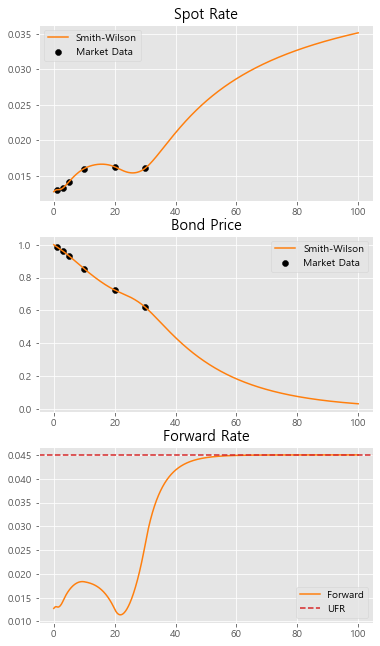

In [269]:
ufr = 0.045
terminal = 60

sw = SmithWilson(np.log(1+ufr), terminal)
sw.train(X_train, y_train)

maturity = np.linspace(0, 100, 1201)
spot_rate_sw = sw.spot(x)
bond_price_sw = sw.bond(x)
forward_rate_sw = sw.forward(maturity)

fig, ax = plt.subplots(3, 1, figsize=(6, 11))
ax[0].plot(maturity, spot_rate_sw, color='#ff7f0e', label='Smith-Wilson')
ax[0].scatter(X_train, y_train, color='black', label='Market Data')
ax[0].set_title('Spot Rate')
ax[0].legend()

ax[1].plot(maturity, bond_price_sw, color='#ff7f0e', label='Smith-Wilson')
ax[1].scatter(X_train, 1/(1+y_train)**X_train, color='black', label='Market Data')
ax[1].set_title('Bond Price')
ax[1].legend()

ax[2].plot(maturity, forward_rate_sw, color='#ff7f0e', label='Forward')
ax[2].axhline(y=ufr, linestyle='--', color='#d62728', label='UFR')
ax[2].legend()
ax[2].set_title('Forward Rate')

plt.show()

In [256]:
class NelsonSiegel:
    
    def train(self, X, y):
        def obj_fun(lambda_):
            design_matrix = np.c_[np.ones_like(X), (1-np.exp(-lambda_*X))/(lambda_*X), (1-np.exp(-lambda_*X))/(lambda_*X)-np.exp(-lambda_*X)]
            beta = np.linalg.inv(design_matrix.T@design_matrix)@design_matrix.T@y
            error = np.sum((y-design_matrix@beta)**2)
            return error
        res = minimize_scalar(obj_fun, method='bounded', bounds=(1e-2,1), options={'disp':False})
        self.lambda_ = res.x
        design_matrix = np.c_[np.ones_like(X), (1-np.exp(-self.lambda_*X))/(self.lambda_*X), (1-np.exp(-self.lambda_*X))/(self.lambda_*X)-np.exp(-self.lambda_*X)]
        self.beta = np.linalg.inv(design_matrix.T@design_matrix)@design_matrix.T@y
    
    def spot(self, t):
        t = np.fmax(t, 1e-6)
        design_matrix = np.c_[np.ones_like(t), (1-np.exp(-self.lambda_*t))/(self.lambda_*t), (1-np.exp(-self.lambda_*t))/(self.lambda_*t)-np.exp(-self.lambda_*t)]
        return design_matrix@self.beta
    
    def bond(self, t):
        return (1+self.spot(t))**(-t)
    
    def forward(self, t):
        t = np.fmax(t, 1e-6)
        design_matrix = np.c_[np.ones_like(t), np.exp(-self.lambda_*t), self.lambda_*t*np.exp(-self.lambda_*t)]
        return design_matrix@self.beta

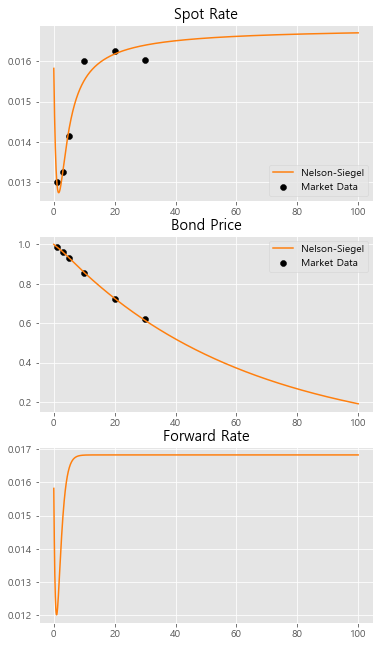

In [257]:
ns = NelsonSiegel()
ns.train(X_train, y_train)
maturity = np.linspace(0, 100, 1201)
spot_rate_ns = ns.spot(x)
bond_price_ns = ns.bond(x)
forward_rate_ns = ns.forward(x)

fig, ax = plt.subplots(3, 1, figsize=(6, 11))
ax[0].plot(maturity, spot_rate_ns, color='#ff7f0e', label='Nelson-Siegel')
ax[0].scatter(X_train, y_train, color='black', label='Market Data')
ax[0].set_title('Spot Rate')
ax[0].legend()

ax[1].plot(maturity, bond_price_ns, color='#ff7f0e', label='Nelson-Siegel')
ax[1].scatter(X_train, 1/(1+y_train)**X_train, color='black', label='Market Data')
ax[1].set_title('Bond Price')
ax[1].legend()

ax[2].plot(maturity, forward_rate_ns, color='#ff7f0e')
ax[2].set_title('Forward Rate')

plt.show()

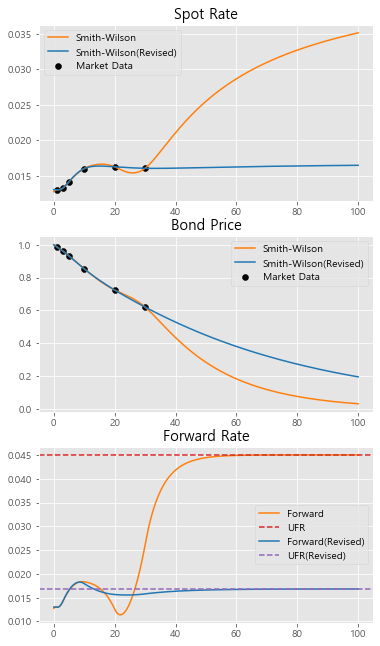

In [258]:
ufr_revised = forward_rate[-1]
sw_revised = SmithWilson(np.log(1+ufr_revised), terminal)
sw_revised.train(X_train, y_train)

maturity = np.linspace(0, 100, 1201)
spot_rate_sw_revised = sw_revised.spot(x)
bond_price_sw_revised = sw_revised.bond(x)
forward_rate_sw_revised = np.exp(sw_revised.forward(x))-1

fig, ax = plt.subplots(3, 1, figsize=(6, 11))
ax[0].plot(maturity, spot_rate_sw, color='#ff7f0e', label='Smith-Wilson')
ax[0].plot(maturity, spot_rate_sw_revised, color='#1f77b4', label='Smith-Wilson(Revised)')
ax[0].scatter(X_train, y_train, color='black', label='Market Data')
ax[0].set_title('Spot Rate')
ax[0].legend()

ax[1].plot(maturity, bond_price_sw, color='#ff7f0e', label='Smith-Wilson')
ax[1].plot(maturity, bond_price_sw_revised, color='#1f77b4', label='Smith-Wilson(Revised)')
ax[1].scatter(X_train, 1/(1+y_train)**X_train, color='black', label='Market Data')
ax[1].set_title('Bond Price')
ax[1].legend()

ax[2].plot(maturity, forward_rate_sw, color='#ff7f0e', label='Forward')
ax[2].axhline(y=ufr, linestyle='--', color='#d62728', label='UFR')
ax[2].plot(maturity, forward_rate_sw_revised, color='#1f77b4', label='Forward(Revised)')
ax[2].axhline(y=ufr_revised, linestyle='--', color='#9467bd', label='UFR(Revised)')
ax[2].legend()
ax[2].set_title('Forward Rate')

plt.show()

In [5]:
class DynamicNelsonSiegel:
    def __init__(self):
        pass
    
    def train(self, X):
        dt = 1/12
        tau = np.array([0.25, 0.5, 0.75, 1, 1.5, 2, 2.5, 3, 5, 7, 10, 15, 20])
        params_init = np.array([ 2.80219511e+01,  3.52105482e+01, -5.58298665e+01, -1.53761445e+03, \
                                -1.07462955e+03,  4.64941686e-03, -3.66842156e-04, -1.95497552e-04, \
                                1.31432197e+00,  8.53989993e+00, -1.82373281e+00,  1.22558346e+00, \
                                -1.66375779e+01, -4.09723444e+01])
        
        def obj_fun(params):
            lambda_, eps, kappa11, kappa22, kappa33, theta1, theta2, theta3, sigma11, sigma21, sigma22, sigma31, sigma32, sigma33 = params
            
            A = np.array([[1-kappa11*dt, 0, 0],
                          [0, 1-kappa22*dt, 0],
                          [0, 0, 1-kappa33*dt]])
            B = np.array([kappa11*theta1, kappa22*theta2, kappa33*theta3])*dt
            L = np.array([[sigma11, 0, 0],
                          [sigma21, sigma22, 0],
                          [sigma31, sigma32, sigma33]])
            Q = dt*L@L.T
            H = np.c_[np.ones_like(tau), (1-np.exp(-lambda_*tau))/(lambda_*tau), (1-np.exp(-lambda_*tau))/(lambda_*tau)-np.exp(-lambda_*tau)]
            R = np.identity(len(tau))*eps**2
        
            x_update = np.zeros_like(B)
            P_update = np.identity(len(x_update))*0.1

            logL = 0
            for i in range(len(X)):
                x_pred = A@x_update+B
                P_pred = A@P_update@A.T+Q

                y = X[i]-H@x_pred
                S = H@P_pred@H.T+R
                S_inv = np.linalg.inv(S)
                K = P_pred@H.T@S_inv
                x_update = x_pred+K@y
                P_update = (np.identity(len(x_pred))-K@H)@P_pred

                detS = np.fmin(np.linalg.det(S), 1e-30)
                logL += -0.5*np.log(2*np.pi) - 0.5*np.log(detS) - 0.5*y.T@S_inv@y
            return -logL
        
        res = minimize(obj_fun, x0=params_init, method='nelder-mead', options={'disp': False})
        return res.x

In [6]:
# 데이터 불러오기
data = np.loadtxt('./data/YieldCurve_KAP_2012_2019.csv', delimiter=',')
maturity = data[0]
int_rate = data[1:]

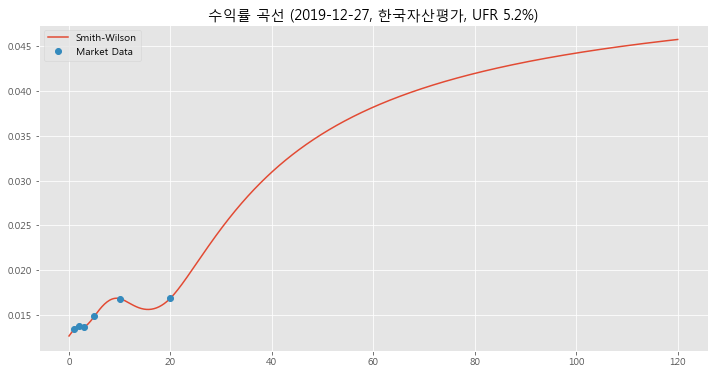

In [7]:
# 수익률 곡선
sw = SmithWilson(0.052, 20)
sw.train(maturity, int_rate[-1])
X_pred = np.linspace(0, 120, 481)
y_pred = sw.predict(X_pred)
plt.figure(figsize=(12,6))
plt.plot(X_pred, y_pred, label='Smith-Wilson')
plt.plot(maturity, int_rate[-1], 'o', label='Market Data')
plt.title('수익률 곡선 (2019-12-27, 한국자산평가, UFR 5.2%)')
plt.legend()
plt.show()

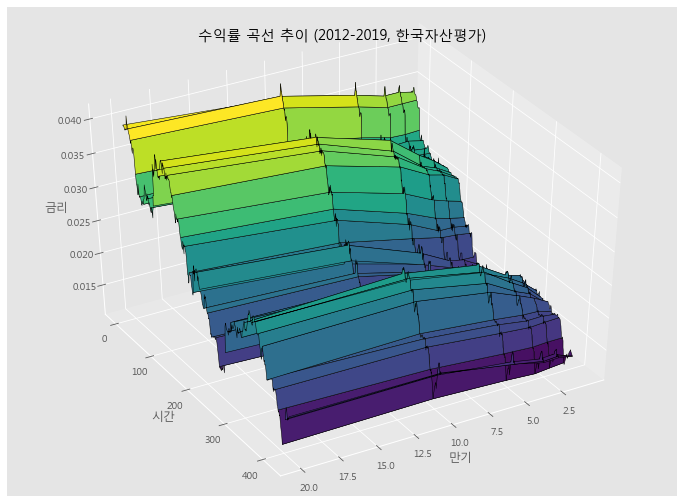

In [10]:
t = np.arange(len(int_rate))
X, Y = np.meshgrid(maturity, t)

fig = plt.figure(figsize=(12,9))
ax = fig.add_subplot(111, projection='3d')
# ax.plot_wireframe(X, Y, int_rate, rstride=5, cstride=1)
ax.plot_surface(X, Y, int_rate, cmap='viridis', edgecolor='black', linewidth=0.5)
ax.view_init(40, 60)

ax.set_xlabel('만기')
ax.set_ylabel('시간')
ax.set_zlabel('금리')
plt.title('수익률 곡선 추이 (2012-2019, 한국자산평가)')
plt.show()

In [11]:
class DynamicNelsonSiegel:
    
    def __init__(self, tau, dt):
        self.tau = tau
        self.dt = dt
    
    def _estimate_init_value(self, X):
        def obj_fun(lambda_):
            design_matrix = np.c_[np.ones_like(self.tau), (1-np.exp(-lambda_*self.tau))/(lambda_*self.tau), (1-np.exp(-lambda_*self.tau))/(lambda_*self.tau)-np.exp(-lambda_*self.tau)]
            beta = np.linalg.inv(design_matrix.T@design_matrix)@design_matrix.T@X.T
            rmse = np.sqrt(np.mean((X.T-design_matrix@beta)**2))
            return rmse
        res = minimize_scalar(obj_fun, method='bounded', bounds=(1e-2,1), options={'disp':False})
        lambda_ = res.x
        eps = obj_fun(lambda_)
        design_matrix = np.c_[np.ones_like(self.tau), (1-np.exp(-lambda_*self.tau))/(lambda_*self.tau), (1-np.exp(-lambda_*self.tau))/(lambda_*self.tau)-np.exp(-lambda_*self.tau)]
        beta = (np.linalg.inv(design_matrix.T@design_matrix)@design_matrix.T@X.T).T
        
        x, y = beta[:-1], beta[1:]
        beta1 = (np.mean(x**2, axis=0)*np.mean(y, axis=0)-np.mean(x, axis=0)*np.mean(x*y, axis=0))/(np.mean(x**2, axis=0)-np.mean(x, axis=0)**2)
        beta2 = (np.mean(x*y, axis=0)-np.mean(x, axis=0)*np.mean(y, axis=0))/(np.mean(x**2, axis=0)-np.mean(x, axis=0)**2)
        kappa = (1-beta2)/self.dt
        theta = beta1/kappa/self.dt
        e = y-(beta1+x*beta2)
        sigma = np.linalg.cholesky(e.T@e/(len(x)-3))/np.sqrt(self.dt)
        # λ, ε, κ, θ, σ
        params_init = np.array([lambda_, eps, kappa[0], kappa[1], kappa[2], theta[0], theta[1], theta[2], sigma[0][0], sigma[1][0], sigma[1][1], sigma[2][0], sigma[2][1], sigma[2][2]])
        return params_init
    
    
    def _loglik(self, X, params):
        lambda_, eps, kappa11, kappa22, kappa33, theta1, theta2, theta3, sigma11, sigma21, sigma22, sigma31, sigma32, sigma33 = params
        
        A = np.array([[1-kappa11*self.dt, 0, 0],
                      [0, 1-kappa22*self.dt, 0],
                      [0, 0, 1-kappa33*self.dt]])
        B = np.array([kappa11*theta1*self.dt, kappa22*theta2*self.dt, kappa33*theta3*self.dt])
        L = np.array([[sigma11, 0, 0],
                      [sigma21, sigma22, 0],
                      [sigma31, sigma32, sigma33]])
        Q = self.dt*L@L.T
        H = np.c_[np.ones_like(self.tau), (1-np.exp(-lambda_*self.tau))/(lambda_*self.tau), (1-np.exp(-lambda_*self.tau))/(lambda_*self.tau)-np.exp(-lambda_*self.tau)]
        R = np.identity(len(self.tau))*eps**2
        
        x_update = np.array([0., 0.,  0.])
        P_update = np.identity(3)*1
        
        logL = 0
        for i in range(len(X)):
            # Predict
            x_pred = A@x_update+B
            P_pred = A@P_update@A.T+Q

            # Measurement
            z_meas = X[i]

            # Update
            z_pred = H@x_pred
            v = z_meas-z_pred
            F = H@P_pred@H.T+R
            F_inv = np.linalg.inv(F)
            detF = np.fmax(np.linalg.det(F), 1e-60)
            K = P_pred@H.T@F_inv
            x_update = x_pred+K@v
            P_update = P_pred-K@H@P_pred
            logL += -0.5*np.log(2*np.pi)-0.5*np.log(detF)-0.5*v.T@F_inv@v
            
        return logL

    def train(self, X):
        params_init = self._estimate_init_value(X)
        params = minimize(lambda p: -self._loglik(X, p), x0=params_init, method='nelder-mead', options={'disp': False}).x
        return params

In [12]:
dns = DynamicNelsonSiegel(maturity, 1./52.)
params_init = dns._estimate_init_value(int_rate)
print(params_init)
params = dns.train(int_rate)

[ 6.18689318e-01  2.38031476e-04  3.65497559e-01  1.28077224e+00
  1.73100901e+00  1.99594279e-02 -7.63534274e-03 -8.75055775e-03
  5.67226481e-03 -5.66228674e-03  4.06577988e-03 -7.98229352e-04
 -6.92951125e-03  9.36931423e-03]


In [18]:
dns._loglik(int_rate, params)

17677.76244784178

In [ ]:
plt.figure(figsize=(12, 8))
x = np.linspace(0.25, 100, 1000)

sw = SmithWilson(ufr=0.045, llp=20)
ns = NelsonSiegel()
for i in range(len(simulation[:100])):
    
#     ns.train(maturity, simulation[i])
#     y = ns.predict(x)
    sw.train(maturity, simulation[i])
    y = sw.predict(x)
    
    plt.plot(x, y)
    
plt.show()